In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import pandas as pd

Assumptions:

- Perfect thermal contact between the boundaries (i.e, the temperature at the mating surfaces are equal)
 

In [2]:
def volume(r1,r2):
    return abs((4/3)*np.pi*(pow(r2/2,3) - pow(r1/2,3)))

def surfArea(r):
    return 4*np.pi*pow(r,2)

def diffusivity(k,rho,cp):
    return k/(rho*cp)

In [3]:
# Given parameters (_t thickness m) (_k conductivity W/mK) (_c sp. heat capacity at const pressure KJ/kg) (_lh latent heat KJ/kg) (_rho density kg/m^3)

# Outer Insulation
minWool_t = 50e-3
minWool_k = 34e-3
minWool_rho = 45.
minWool_cp = 1030.
minWool_tempInit = 18.

# Dry Ice
co2_t = 30e-3
co2_k = 146e-4
co2_cp = 0.658e3
co2_rho = 1.977
co2_h = 2.2
co2_tempInit = 0.

# PCM x: array([1.00000089e+01, 4.90593175e+03, 1.10000000e+00, 2.20000000e+00, 6.58701213e+00])

PCM_k = 12.504
PCM_c = 2.178e3
PCM_h = 1.1
PCM_t = 30e-3
PCM_rho = 85.2# 99.#85.
PCM_tempInit = -27.

# Outside/ Ambient parameters

amb_h = 5. #w/m2K
amb_temp = 25. #c

coeff = 6.467

In [4]:
minWool_Diff = diffusivity(minWool_k,minWool_rho,minWool_cp)
co2_diff = diffusivity(co2_k,co2_rho,co2_cp)
PCM_diff = diffusivity(PCM_k, PCM_rho, PCM_c)

biot_minWool = amb_h*minWool_t/minWool_k
biot_co2 = co2_h*co2_t/co2_k
biot_PCM = PCM_h*PCM_t/PCM_k

In [5]:
def eigenRoots(Bi):

    val = []
    CN = []
    for n in range (1,500): val.append(fsolve(lambda y: y*np.tan(y) - Bi, n))
    uniqueRoots = np.unique(np.around(np.concatenate(val,axis=0), decimals=4)) #this nested function initially flattens the list of ndarray objects into individual numpy float64 elements which are then rounded to 4 decimal places and then the unique values of them are extracted using np.unique() function 
    for n in range(0,100):
        CN.append((4*np.sin(uniqueRoots[n])) / ((2*uniqueRoots[n]) + np.sin(2*uniqueRoots[n])))
        
    return uniqueRoots,CN

$ Bi = \frac{hL}{k} $

$ \zeta_n tan(\zeta_n) = Bi $

$ Fo = \frac{\alpha \cdot t}{L^2} $ 

$ x^* = \frac{x}{L} $

$ \theta^* = \sum_{n = 1}^{\infty} C_{n} exp(- \zeta_{n}^2 Fo) cos(\zeta_{n}x^*)$ 

$ \theta^* = \frac{T - T_{\infty}}{T_{i} - T_{\infty}} $

$ T_{(x,t)} = [(T_i - T_\infty) \cdot \sum_{n = 1}^{\infty} C_{n} exp(- \zeta_{n}^2 Fo) cos(\zeta_{n}x^*)] + T_\infty ] $

3.8609124434377913
24.579061216199804
24.579061216199804


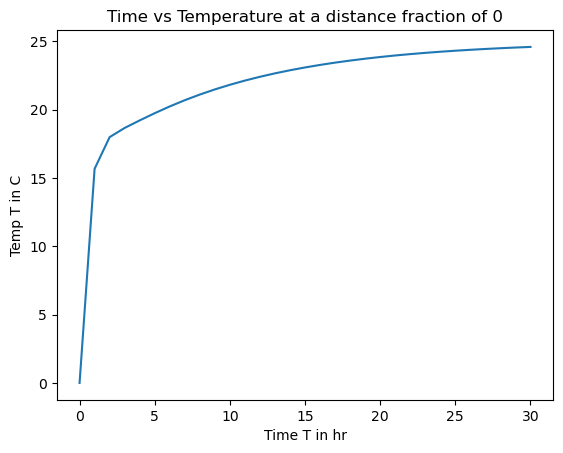

In [6]:
def tAtXandT(cn, z, a, t, l, xS):   
    fo =  a * t / l
    return cn * np.exp(-z**2 * fo) * np.cos(z*xS)

minWoolTvst = []
co2Tvst = []
PCMTvst = []
x = 0
time = 30 #in hours

U1,R1 = eigenRoots(biot_minWool)
U2,R2 = eigenRoots(biot_co2)
U3,R3 = eigenRoots(biot_PCM)

for t in range(0,(time+1)*3600,3600):
    theta = 0.0
    for i in range (0,100):
        theta += tAtXandT(R1[i], U1[i], minWool_Diff, t, minWool_t, x)
        minWool_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp
    minWoolTvst.append(minWool_tempxt)
    
    theta = 0.0 
    for i in range (0,100):
        theta += tAtXandT(R2[i], U2[i], co2_diff, t, co2_t, x)
        co2_tempxt = (co2_tempInit - minWool_tempxt)*theta + minWool_tempxt
    co2Tvst.append(co2_tempxt)
    
    theta = 0.0 
    for i in range (0,100):
        theta += tAtXandT(R3[i], U3[i], PCM_diff, t, PCM_t, x)
        PCM_tempxt = (PCM_tempInit - co2_tempxt)*theta + co2_tempxt + coeff
    PCMTvst.append(PCM_tempxt)

plt.plot(co2Tvst)
plt.title(f'Time vs Temperature at a distance fraction of {x}')
plt.xlabel('Time T in hr')
plt.ylabel('Temp T in C')
print(PCMTvst[-1])
print(co2Tvst[-1])
print(minWoolTvst[-1])
co2data = np.array(co2Tvst).round(2)
minwooldata = np.array(minWoolTvst).round(2)
pcmdata = np.array(PCMTvst).round(4)

pd.DataFrame({'minwool': minwooldata.ravel(), 'co2data':co2data.ravel(), 'pcmdata':pcmdata.ravel()}).to_csv('co2tvstData.csv')

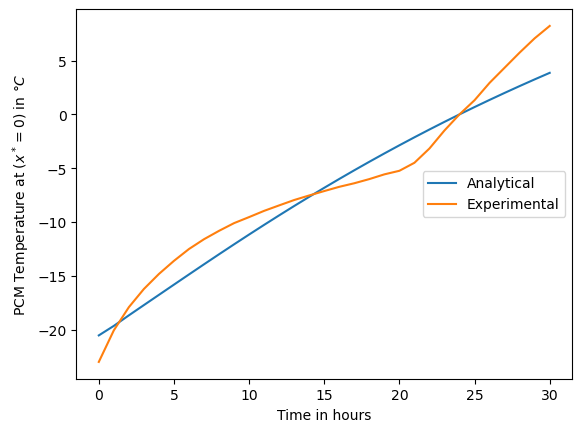

In [7]:
exp_val = np.loadtxt('data.txt')
exp_hr_val = exp_val[0:1801:60]
plt.plot(PCMTvst, label='Analytical')
plt.plot(exp_hr_val, label='Experimental')
plt.xlabel('Time in hours')
plt.ylabel('PCM Temperature at ($x^* = 0$) in $\degree C$')
plt.legend(loc='center right')

plt.show()


24.579061216199804


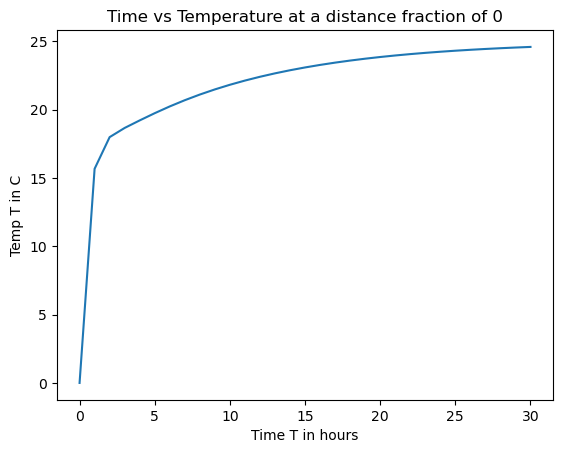

In [8]:
plt.plot(co2Tvst)
plt.title(f'Time vs Temperature at a distance fraction of {x}')
plt.xlabel('Time T in hours')
plt.ylabel('Temp T in C')
print(co2Tvst[-1])

The temperature at cold and hot ends are 23.077 and 24.644


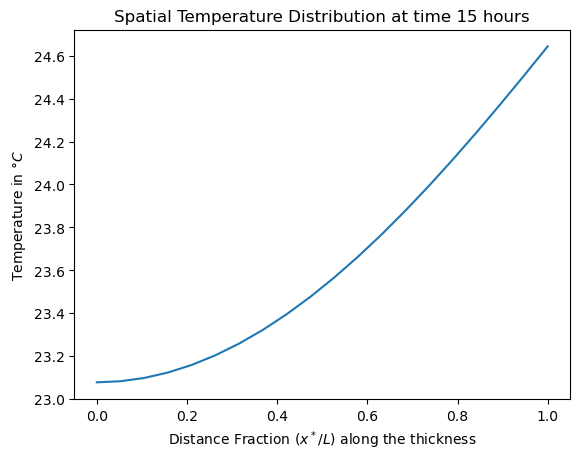

In [9]:
def SpVar(t):

    time = t*3600
    minwoolSpVarData = []
    co2SpVarData = []
    PCMSpVarData = []
    spVar = np.linspace(0,1,20)
    for x in spVar:
        theta = 0.0
        for i in range(0,100):
            theta += tAtXandT(R1[i], U1[i], minWool_Diff, time, minWool_t, x)
        minWool_tempxt = (minWool_tempInit - amb_temp)*theta + amb_temp        
        minwoolSpVarData.append(minWool_tempxt)
        
        theta = 0.0 
        for i in range (0,100):
            theta += tAtXandT(R2[i], U2[i], co2_diff, time, co2_t, x)
            co2_tempxt = (co2_tempInit - minWool_tempxt)*theta + minWool_tempxt
        co2SpVarData.append(co2_tempxt)
        
        theta = 0.0 
        for i in range (0,100):
            theta += tAtXandT(R3[i], U3[i], PCM_diff, time, PCM_t, x)
            PCM_tempxt = (PCM_tempInit - co2_tempxt)*theta + co2_tempxt + coeff
        PCMSpVarData.append(PCM_tempxt.round(4))
        
    plotData = co2SpVarData    
    plt.plot(spVar,plotData)
    plt.title(f'Spatial Temperature Distribution at time {t} hours' )
    plt.ylabel('Temperature in $\degree C$')
    plt.xlabel('Distance Fraction ($x^*/L$) along the thickness')

    print(f'The temperature at cold and hot ends are {round(plotData[0],3)} and {round(plotData[-1],3)}')
    
    return np.array(minwoolSpVarData), np.array(co2SpVarData), np.array(PCMSpVarData), np.array(spVar)
    
mSpv, cSpv, pSpv, Spv = SpVar(15)

pd.DataFrame({'Distance Fraction': Spv.ravel(), 'PCM Spv':pSpv.ravel(), 'co2 spv':cSpv.ravel(), 'minwool spv':mSpv.ravel()}).to_csv('SpVarData15hr.csv')

In [ ]:
# df0 = pd.read_csv('xenontvstData.csv')
# df1 = pd.read_csv('argontvstData.csv')
# df2 = pd.read_csv('airtvstData.csv')
# df3 = pd.read_csv('co2tvstData.csv')
# df4 = pd.read_csv('kryptontvstData.csv')

# plt.figure()
# plt.plot(df0['pcmdata'])
# plt.plot(df1['pcmdata'])
# plt.plot(df2['pcmdata'])
# plt.plot(df3['pcmdata'])
# plt.plot(df4['pcmdata'])
# plt.legend(['xenon', 'argon', 'air', 'co2', 'krypton'])